# AutoEIS demo (detailed)

## Set up the environment 🔌

AutoEIS relies on `EquivalentCircuits.jl` package to perform the EIS analysis. The package is not written in Python, so we need to install it first. AutoEIS ships with `julia_helpers` module that helps to install and manage Julia dependencies with minimal user interaction. The only thing you need to do is to run `autoeis.julia_helpers.install()`, and everything will be taken care of. You only need to do this once.

In [1]:
import arviz as az
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import pandas as pd
import seaborn as sns
from IPython.display import clear_output, display
from tqdm.notebook import tqdm

import autoeis as ae
from autoeis import julia_helpers

ae.visualization.set_plot_style()

PATH_TESTDATA = "assets/test_data.txt"
PATH_EXPORT = "results"

# If Julia executable not in PATH, add it here (not needed if you use `juliaup` to install Julia)
# julia_helpers.add_to_PATH(PATH_TO_JULIA_BIN_DIR)

# Uncomment this line if you are running the code for the first time
# julia_helpers.install()

## Load EIS data 📈

Once the environment is set up, we can load the EIS data. You can use [`pyimpspec`](https://vyrjana.github.io/pyimpspec/guide_data.html) to load EIS data from a variety of popular formats. Eventually, AutoEIS requires two arrays: `Z` and `freq`. `Z` is a complex impedance array, and `freq` is a frequency array. Both arrays must be 1D and have the same length. The impedance array must be in Ohms, and the frequency array must be in Hz.

Here, we use `numpy` to load the test data from a txt file, which contains the frequency array in the first column and the impedance array in the second and third columns (Re and -Im parts). We then convert the impedance array to complex numbers, and it should be ready to use.

In [2]:
# Load impedance data (skip header row); Columns 1 -> 3: frequency, Re(Z), Im(Z)
freq, Zreal, Zimag = np.loadtxt(PATH_TESTDATA, skiprows=1, unpack=True, usecols=(0, 1, 2))
# Convert to complex impedance (the file contains -Im(Z) hence the minus sign)
Z = Zreal - 1j*Zimag

Now let's plot the data using AutoEIS's built-in plotting function. The function takes the impedance array and the frequency array as inputs. It will plot the impedance spectrum in the Nyquist plot and the Bode plot. All plotting functions in AutoEIS can either be directly called or an `Axes` object can be passed in to specify the plotting location.

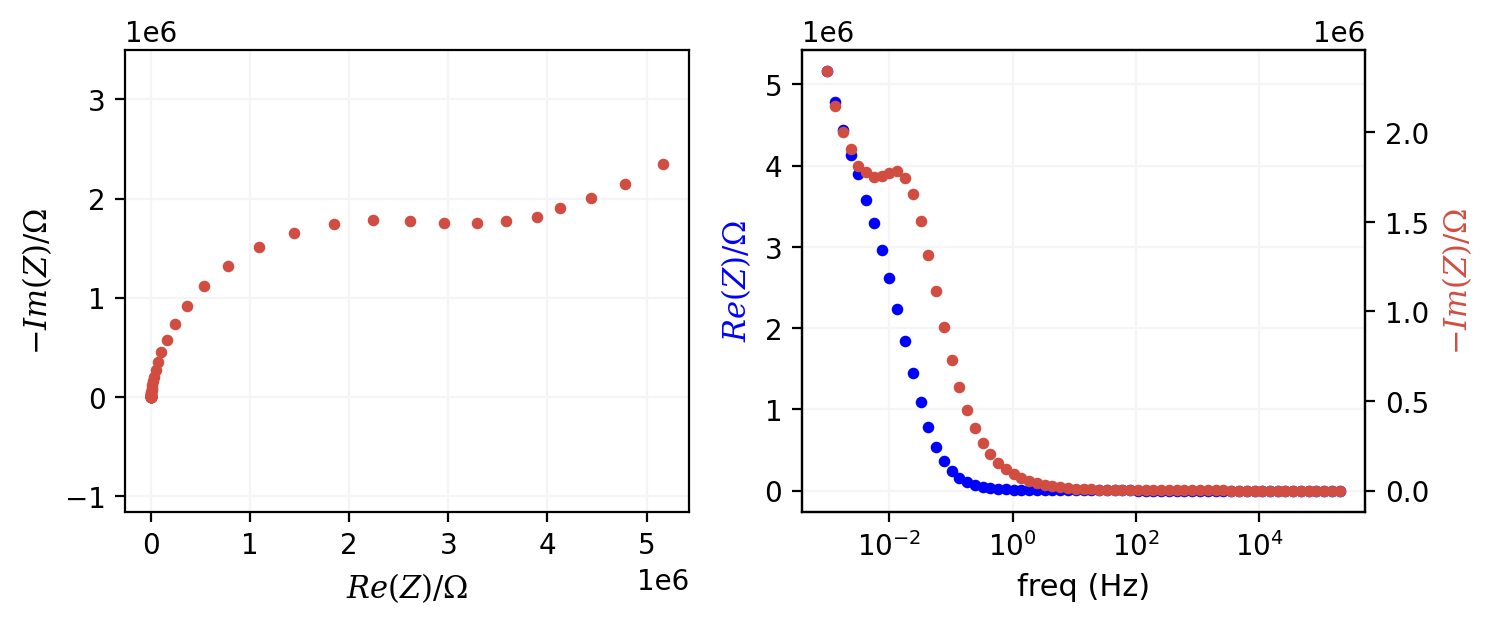

In [3]:
fig, ax = ae.visualization.plot_impedance_combo(Z, freq)

# Alternatively, you can manually create a subplot and pass it to the plotting function
# Make sure to create two columns for the two plots (Nyquist and Bode)
# fig, ax = plt.subplots(ncols=2)
# ae.visualization.plot_impedance_combo(Z, freq, ax=ax)

## EIS analysis 🪄

## Preprocess impedance data 🧹
Before performing the EIS analysis, we need to preprocess the impedance data. The preprocessing step is to remove outliers. AutoEIS provides a function to perform the preprocessing. As part of the preprocessing, the impedance measurements with a positive imaginary part are removed, and the rest of the data are filtered using linear KK validation. The function returns the filtered impedance array and the frequency array.

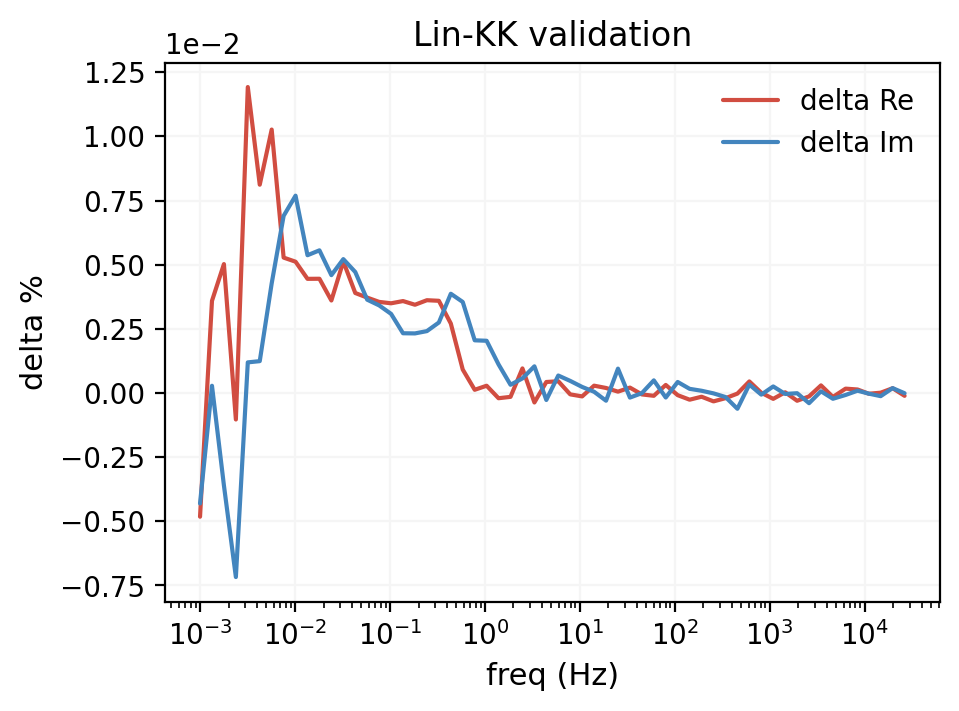

In [4]:
Z, freq, rmse = ae.core.preprocess_impedance_data(Z, freq, threshold=5e-2, plot=True)

## Generate candidate equivalent circuits 📐

In this stage, AutoEIS generates a list of candidate equivalent circuits using a customized genetic algorithm (done via the package `EquivalentCircuits.jl`). The function takes the filtered impedance array and the frequency array as inputs. It returns a list of candidate equivalent circuits. The function has a few optional arguments that can be used to control the number of candidate circuits and the circuit types. The default number of candidate circuits is 10, and the default circuit types are resistors, capacitors, constant phase elements, and inductors. The function runs in parallel by default, but you can turn it off by setting `parallel=false`.

In [134]:
kwargs = {
    "iters": 24,
    "complexity": 12,
    "population_size": 100,
    "generations": 30,
    "tol": 1e-4,
    "parallel": True
}
circuits_unfiltered = ae.core.generate_equivalent_circuits(Z, freq, **kwargs)
# Since generating circuits is expensive, let's save the results to a CSV file
circuits_unfiltered.to_csv(f"{PATH_EXPORT}/circuits_unfiltered.csv", index=False)
circuits_unfiltered

,circuitstring,Parameters
0,"[[[R1,L2],R3]-P4,R5-P6]","{'R1': 86870019.93164168, 'L2': 1.000637417924..."
1,"[R1-P2,R3-P4]","{'R1': 141.2473463216246, 'P2w': 1.81712843798..."
2,"[P1,R2-[R3,P4]]-P5","{'P1w': 1.824104533412197e-06, 'P1n': 0.954903..."
3,"[[R1,P2]-R3-P4,P5]","{'R1': 864235389.9218115, 'P2w': 734373406.590..."
4,"P1-[[R2,P3],[R4,P5]]-R6","{'P1w': 5.271886412848184e-05, 'P1n': 0.800129..."
5,"P1-R2-[P3,[P4,R5]]","{'P1w': 5.280175523133987e-05, 'P1n': 0.800129..."
6,"[R1,P2]-P3-[P4,P5]","{'R1': 1406531047.1580005, 'P2w': 0.0071149981..."
7,"[R1-P2-L3,P4-R5]","{'R1': 141.24734638415853, 'P2w': 1.8171284371..."
8,"[P1,R2-P3-[P4,[P5,R6]]]","{'P1w': 2.2329592851158255e-06, 'P1n': 0.87632..."
9,"P1-[[R2,P3],P4]-R5","{'P1w': 5.280178593621143e-05, 'P1n': 0.800129..."


## Filter candidate equivalent circuits 🧹

Note that all these circuits generated by the GEP process probably fit the data well, but they may not be physically meaningful. Therefore, we need to filter them to find the ones that are most plausible. AutoEIS uses "statistical plausibility" as a proxy for gauging "physical plausibility". To this end, AutoEIS provides a function to filter the candidate circuits based on some heuristics (read our [paper](https://doi.org/10.1149/1945-7111/aceab2) for the exact steps and the supporting rationale).

In [5]:
circuits = ae.core.apply_heuristic_rules(circuits_unfiltered)
# Let's save the filtered circuits to a CSV file as well
circuits.to_csv(f"{PATH_EXPORT}/circuits_filtered.csv", index=False)
# To load from file, uncomment the next 2 lines (line 2 is to convert str -> Python objects)
# circuits = pd.read_csv(f"{PATH_EXPORT}/circuits_filtered.csv")
# circuits["Parameters"] = circuits["Parameters"].apply(eval)
circuits

,circuitstring,Parameters,Resistors,Capacitors,Inductors,CPEs
0,"P1-[[R2,P3],[R4,P5]]-R6","{'P1w': 5.271886412848184e-05, 'P1n': 0.800129...","['R2', 'R4', 'R6']",[],[],"['P1w', 'P1n', 'P3w', 'P3n', 'P5w', 'P5n']"
1,"P1-R2-[P3,[P4,R5]]","{'P1w': 5.280175523133987e-05, 'P1n': 0.800129...","['R2', 'R5']",[],[],"['P1w', 'P1n', 'P3w', 'P3n', 'P4w', 'P4n']"


## Perform Bayesian inference 🧮

Now that we have narrowed down the candidate circuits to a few good ones, we can perform Bayesian inference to find the ones that are statistically most plausible.

In [6]:
mcmc_list = []

for row in tqdm(circuits.itertuples(), total=len(circuits)):
    circuit = row.circuitstring
    p0_dict = row.Parameters
    # Get another set of initial guesses using impedance.py (not guaranteed to converge)
    p0_fit = ae.utils.fit_circuit_parameters(circuit, Z, freq, p0=p0_dict)
    kwargs_mcmc = {"num_warmup": 2500, "num_samples": 1000, "progress_bar": False}
    mcmc = ae.core.perform_bayesian_inference(circuit, Z, freq, p0_fit, **kwargs_mcmc)
    mcmc_list.append(mcmc)

  0%|          | 0/2 [00:00<?, ?it/s]

## Visualize results 📊

Now, let's take a look at the results. `perform_bayesian_inference` returns a list of `MCMC` objects. Each `MCMC` object contains all the information about the Bayesian inference, including the posterior distribution, the prior distribution, the likelihood function, the trace, and the summary statistics.

Before we visualize the results, let's take a look at the summary statistics. The summary statistics are the mean, the standard deviation, and the 95% credible interval of the posterior distribution. The summary statistics are useful for quickly gauging the uncertainty of the parameters.

In [7]:
for mcmc, circuit in zip(mcmc_list, circuits.circuitstring):
    ae.visualization.print_summary_statistics(mcmc, circuit)

             P1-[[R2,P3],[R4,P5]]-R6, 0/1000 divergences             
┏━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃  Parameter ┃     Mean ┃      Std ┃   Median ┃     5.0% ┃    95.0% ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│        P1n │ 5.87e-01 │ 1.89e-03 │ 5.87e-01 │ 5.84e-01 │ 5.90e-01 │
│        P1w │ 1.23e-05 │ 2.09e-07 │ 1.23e-05 │ 1.19e-05 │ 1.26e-05 │
│        P3n │ 1.00e+00 │ 4.41e-05 │ 1.00e+00 │ 1.00e+00 │ 1.00e+00 │
│        P3w │ 2.05e-06 │ 6.27e-09 │ 2.05e-06 │ 2.04e-06 │ 2.06e-06 │
│        P5n │ 1.25e-01 │ 6.30e-04 │ 1.25e-01 │ 1.24e-01 │ 1.26e-01 │
│        P5w │ 4.37e-07 │ 4.92e-10 │ 4.37e-07 │ 4.36e-07 │ 4.38e-07 │
│         R2 │ 2.74e+14 │ 4.88e+15 │ 7.51e+10 │ 1.97e+09 │ 9.19e+12 │
│         R4 │ 3.57e+12 │ 2.85e+13 │ 4.23e+10 │ 2.56e+09 │ 6.93e+12 │
│         R6 │ 9.68e+00 │ 1.96e+01 │ 2.86e+00 │ 4.24e-03 │ 4.00e+01 │
│ sigma_imag │ 2.01e+03 │ 3.49e+01 │ 2.01e+03 │ 1.95e+03 │ 2.07e+03 │
│ sigma_real │ 2.31e+03 │ 3.66e+01 │ 2.30e+03 │ 2.25e+03 │ 2.37e+03 │
└────────────┴──────────┴──────────┴──────────┴──────────┴──────────┘

               P1-R2-[P3,[P4,R5]], 0/1000 divergences                
┏━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃  Parameter ┃     Mean ┃      Std ┃   Median ┃     5.0% ┃    95.0% ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│        P1n │ 5.87e-01 │ 1.95e-03 │ 5.87e-01 │ 5.83e-01 │ 5.90e-01 │
│        P1w │ 1.23e-05 │ 2.17e-07 │ 1.23e-05 │ 1.19e-05 │ 1.26e-05 │
│        P3n │ 1.00e+00 │ 4.48e-05 │ 1.00e+00 │ 1.00e+00 │ 1.00e+00 │
│        P3w │ 2.05e-06 │ 6.49e-09 │ 2.05e-06 │ 2.04e-06 │ 2.06e-06 │
│        P4n │ 1.25e-01 │ 6.43e-04 │ 1.25e-01 │ 1.24e-01 │ 1.26e-01 │
│        P4w │ 4.37e-07 │ 4.51e-10 │ 4.37e-07 │ 4.37e-07 │ 4.38e-07 │
│         R2 │ 1.00e+01 │ 2.02e+01 │ 2.07e+00 │ 1.38e-02 │ 5.46e+01 │
│         R5 │ 1.23e+15 │ 1.54e+16 │ 4.57e+10 │ 2.18e+09 │ 8.55e+12 │
│ sigma_imag │ 2.01e+03 │ 3.54e+01 │ 2.01e+03 │ 1.95e+03 │ 2.07e+03 │
│ sigma_real │ 2.31e+03 │ 3.90e+01 │ 2.30e+03 │ 2.24e+03 │ 2.37e+03 │
└────────────┴──────────┴──────────┴──────────┴──────────┴──────────┘

Note that some rows have been highlighted in yellow, indicating that the standard deviation is greater than the mean. This is not necessarily a bad thing, but it screams "caution" due to the high uncertainty. In this case, we need to check the data and the model to see if there is anything wrong. For example, the data may contain outliers, or the model may be overparameterized.

Now, let's take one step further and visualize the results. To get an overview of the results, we can plot the posterior distributions of the parameters as well as the trace plots. It's an oversimplification, but basically, a good posterior distribution should be unimodal and symmetric, and the trace plot should be stationary. In probabilistic terms, this means that given the circuit model, the data are informative about the parameters, and the MCMC algorithm has converged. 

On the other hand, if the posterior distribution is multimodal or skewed, or the trace plot is not stationary, it means that the data are not informative about the parameters, and the MCMC algorithm has not converged. In this case, we need to check the data and the model to see if there is anything wrong. For example, the data may contain outliers, or the model may be overparameterized.

In [8]:
def plot_trace(mcmc: "numpyro.MCMC", variable: str):
    """Plots the posterior and trace of a variable in the MCMC sampler."""
    samples = mcmc.get_samples()[variable]
    out = widgets.Output()
    with out:
        fig, ax = plt.subplots(ncols=2, figsize=(9, 3))
        log_scale = bool(np.std(samples) / np.median(samples) > 4)
        kwargs_hist = {"stat": "density", "log_scale": log_scale, "color": "lightblue", "bins": 25}
        # ax[0,0] -> posterior, ax[0,1] -> trace
        sns.histplot(samples, **kwargs_hist, ax=ax[0])
        kwargs_kde = {"log_scale": log_scale, "color": "red"}
        sns.kdeplot(samples, **kwargs_kde, ax=ax[0])
        # Plot trace
        ax[1].plot(samples, alpha=0.5)
        ax[1].set_yscale("log" if log_scale else "linear")
        # <<<
        plt.show(fig)
    return out


def plot_trace_all(mcmc: "numpyro.MCMC", circuit: str):
    variables = ae.utils.get_parameter_labels(circuit)
    children = [plot_trace(mcmc, variable) for variable in variables]
    tab = widgets.Tab()
    tab.children = children
    tab.titles = variables
    return tab


def plot_trace_batch(mcmc_list: list["numpyro.MCMC"], circuits: list[str]):
    children = [plot_trace_all(mcmc, circuit) for mcmc, circuit in zip(mcmc_list, circuits)]
    tab = widgets.Tab()
    tab.children = children
    tab.titles = circuits
    return tab


def dropdown_trace_plots():
    """Creates a dropdown menu to select a circuit and plot its trace."""
    def on_change(value):
        idx = circuits_str.index(value["new"])
        plot = trace_plots[idx]
        clear_output()
        display(dropdown)
        display(plot)

    dropdown = widgets.Dropdown(options=circuits_str, value=None, description='Circuit:')
    dropdown.observe(on_change, names='value')
    return display(dropdown)

# Cache rendered plots to avoid re-rendering
circuits_str = circuits["circuitstring"].tolist()
trace_plots = [plot_trace_all(mcmc, circuit) for mcmc, circuit in zip(mcmc_list, circuits_str)]

dropdown_trace_plots()

Dropdown(description='Circuit:', index=1, options=('P1-[[R2,P3],[R4,P5]]-R6', 'P1-R2-[P3,[P4,R5]]'), value='P1…

The functions defined in the above cell are used to make the interactive dropdown menu. The dropdown menu lets you select a circuit model, and shows the posterior distributions of the parameters as well as the trace plots. The dropdown menu is useful for quickly comparing the results of different circuit models. Running this cell for the first time may take a while (~ 5 seconds per circuit), but once run, all the plots will be cached.

The distributions for the most part look okay, although in some cases (like R2 and R4 in the first circuit) the span is quite large (~ few orders of magnitude). Nevertheless, the distributions are bell-shaped. The trace plots also look stationary.

Now, let's take a look at the posterior predictive distributions. "Posterior predictive" is a fancy term for "model prediction", meaning that after we have performed Bayesian inference, we can use the posterior distribution to make predictions. In this case, we can use the posterior distribution to predict the impedance spectrum and compare it with our measurements and see how well they match. After all, all the posteriors might look good (bell-shaped, no multimodality, etc.) but if the model predictions don't match the data, then the model is not good.


In [9]:
def plot_nyquist(mcmc: "numpyro.MCMC", circuit: str):
    """Plots Nyquist plot of the circuit using the median of the posteriors."""
    # Compute circuit impedance using median of posteriors
    samples = mcmc.get_samples()
    variables = ae.utils.get_parameter_labels(circuit)
    percentiles = [10, 50, 90]
    params_list = [[np.percentile(samples[v], p) for v in variables] for p in percentiles]
    circuit_fn = ae.utils.generate_circuit_fn(circuit)
    Zsim_list = [circuit_fn(params, freq) for params in params_list]
    # Plot Nyquist plot
    out = widgets.Output()
    with out:
        fig, ax = plt.subplots(figsize=(5.5, 4))
        for p, Zsim in zip(percentiles, Zsim_list):
            ae.visualization.plot_nyquist(Zsim, label=f"model ({p}%)", ax=ax)
        ae.visualization.plot_nyquist(Z, "o", label="measured", ax=ax)
        plt.show(fig)
    return out


def dropdown_nyquist_plots():
    """Creates a dropdown menu to select a circuit and plot its Nyquist plot."""
    def on_change(value):
        idx = circuits_str.index(value["new"])
        plot = nyquist_plots[idx]
        clear_output()
        display(dropdown)
        display(plot)

    dropdown = widgets.Dropdown(options=circuits_str, value=None, description='Circuit:')
    dropdown.observe(on_change, names='value')
    display(dropdown)

# Cache rendered plots to avoid re-rendering
circuits_str = circuits["circuitstring"].tolist()
nyquist_plots = [plot_nyquist(mcmc, circuit) for mcmc, circuit in zip(mcmc_list, circuits_str)]

dropdown_nyquist_plots()

Dropdown(description='Circuit:', index=1, options=('P1-[[R2,P3],[R4,P5]]-R6', 'P1-R2-[P3,[P4,R5]]'), value='P1…

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 550x400 with 1 Axes>', 'i…